In [7]:
import os
import torch
import numpy as np
import pandas as pd

import scanpy as sc
from anndata import AnnData

In [8]:
import matplotlib.pyplot as plt
# Set global font sizes using rcParams
plt.rcParams.update({
    'font.size': 18,            # Global font size
    'axes.titlesize': 20,       # Font size of the axes title
    'axes.labelsize': 20,       # Font size of the x and y labels
    'xtick.labelsize': 16,      # Font size of the x-tick labels
    'ytick.labelsize': 16,      # Font size of the y-tick labels
    'legend.fontsize': 18,      # Font size of the legend
    'figure.titlesize': 24      # Font size of the figure title
})

In [9]:
data_dir="../../data/Mouse_brain/processed1/"
result_dir = "../edges/"
raw_type=False
use_edge=False

str_cell_type='subclass'
str_x='centerx'
str_y='centery'

sample='mouse1_slice201'
top_genes=['Cux2', 'Trp53i11', 'Slc17a7', 'Fam19a2', 'Syndig1', 'Rab3b', 'Slc30a3', 'Sulf2', 'Ptprt', 'Lamp5', 'Igfbp4', 'C1ql3', 'Rspo1', 'Calb1', 'Grm1', 'Cdh12', 'Gfap', 'Sema5a', 'Wipf3', 'Slc17a6', 'Rorb', 'Fezf2', 'Cbln2', 'Meis2', 'Thsd7a', 'Unc5d']#['Sulf2', 'Rorb', 'Lamp5', 'C1ql3', 'Rspo1', 'Slc17a7', 'Cux2']
top_genes=['Rorb','Gfap','Sulf2','Cux2','Nos1']
gene_list = torch.load("/".join(data_dir.split("/")[:-2]) + "/genes.pth")

In [10]:
def read_data(sample,idx,select=10,loss_threshold=10,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth",map_location=torch.device('cpu'))
    edges=results["edges"]

    # modify here
    if normalize:
        attention_score=torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
        
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    '''
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True)
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    '''
    indices=torch.topk(attention_score[:,:,idx],k=select,dim=-1)[1]

    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edge=attention_score
    edges=edge[indices[0],indices[1],:].reshape(-1,edge.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    cell_types_pair=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"__"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"__"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
    print(edges.shape)
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    
    adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
    return adata

def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]
    
    sc.tl.pca(adata_filtered, n_comps=10)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata

#adata=read_data('mouse1_slice201',select=5)
#print(adata)

In [11]:
def load_sample_position(sample,add_column=True):
    df = pd.read_csv(data_dir+sample+".csv")
    # Step 1: Create a new column based on conditions
    df['Excitatory Neuron'] = df[str_cell_type].apply(lambda x: x.split(" ")[0] if x.startswith('L') and x[1]<'9' and x[1]>'0' else "Not EN")
    return df

df_position=load_sample_position(sample)

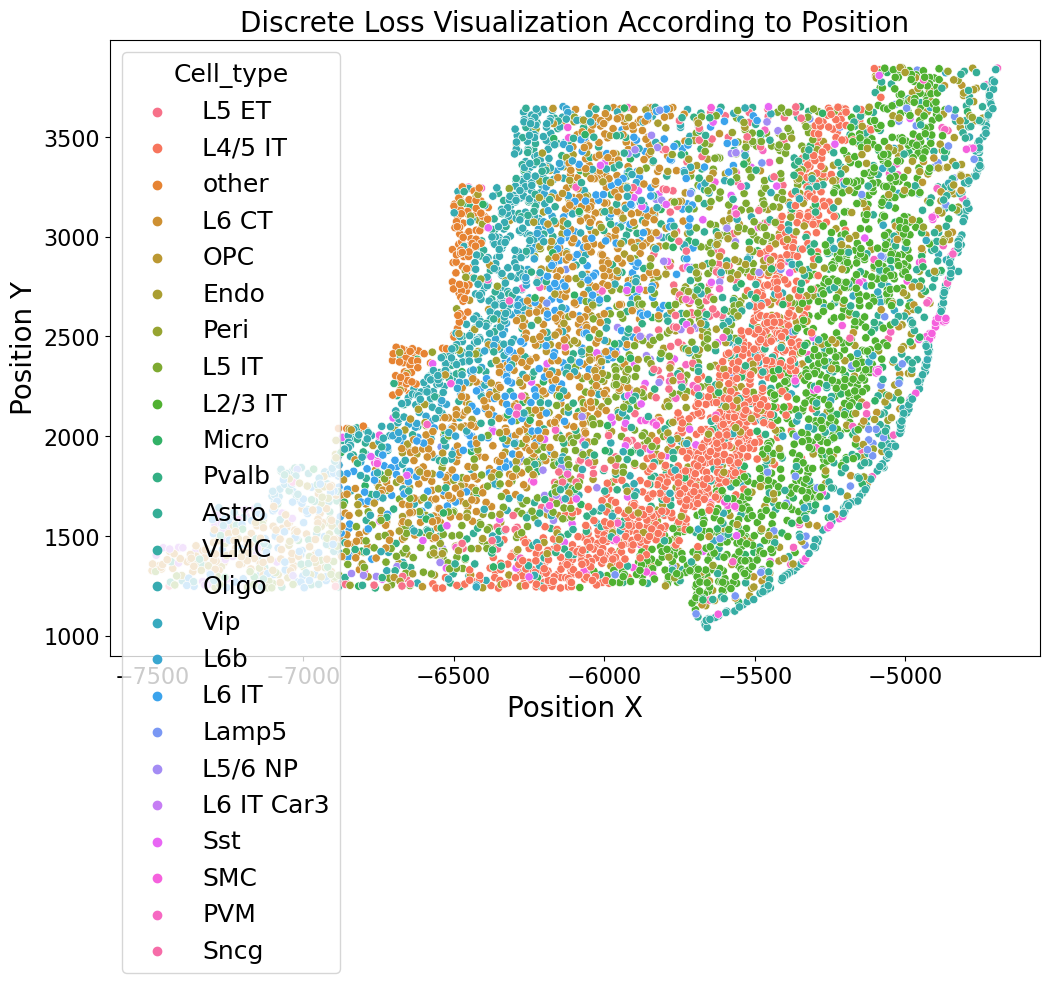

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.lines as mlines

def plot_type(df):
    """
    Plots a scatter plot for a DataFrame with discrete 'loss_all' values.

    Parameters:
    df (DataFrame): Pandas DataFrame with columns 'loss_all', 'position_x', 'position_y'
    """

    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=df, x='centerx', y='centery', hue='subclass', legend='full')

    # Customizing the plot
    plt.title('Discrete Loss Visualization According to Position')
    plt.xlabel('Position X')
    plt.ylabel('Position Y')
    plt.legend(title='Cell_type')

    # Display the plot
    plt.show()

plot_type(df_position)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def plot_info_flow(sample,df_position,idx,title,cutoff=0.05,cutoff_type="percentage",select=5):
    adata=read_data(sample,idx,select=select)
    from_x = adata.obs['from_position_x']
    from_y = adata.obs['from_position_y']
    to_x = adata.obs['to_position_x']
    to_y = adata.obs['to_position_y']
    values = adata.X[:, idx]

    flag = [values[i] >= cutoff for i in range(values.shape[0])]
    if cutoff_type=="percentage":
        retain_number=int(values.shape[0]*cutoff)
        args=np.argsort(-values)[:retain_number]
        flag=[i for i in range(values.shape[0]) if i in args.tolist()]
    from_x = from_x[flag]
    from_y = from_y[flag]
    to_x = to_x[flag]
    to_y = to_y[flag]
    values = values[flag]

    # Calculate differences for arrow directions
    dx = to_x - from_x
    dy = to_y - from_y

    # Normalize the values for coloring
    norm = plt.Normalize(values.min(), values.max())

    # Create a colormap
    cmap = plt.cm.jet

    # Create a figure
    width=np.max(df_position.loc[:,str_x])-np.min(df_position.loc[:,str_x])
    height=np.max(df_position.loc[:,str_y])-np.min(df_position.loc[:,str_y])
    fig, ax = plt.subplots(figsize=(10*(width/height+0.25), 10))
    
    # Plotting the arrows using quiver
    scatter = sns.scatterplot(data=df_position, x=str_x, y=str_y, hue='Excitatory Neuron', ax=ax)
    
    # Set the x and y axis limits
    min_x_value=min(np.min(adata.obs['from_position_x']),np.min(adata.obs['to_position_x']))
    min_y_value=min(np.min(adata.obs['from_position_y']),np.min(adata.obs['to_position_y']))
    max_x_value=max(np.max(adata.obs['from_position_x']),np.max(adata.obs['to_position_x']))
    max_y_value=max(np.max(adata.obs['from_position_y']),np.max(adata.obs['to_position_y']))
    ax.set_xlim([min_x_value, max_x_value])  # Replace with your desired limits
    ax.set_ylim([min_y_value, max_y_value])  # Replace with your desired limits
    
    # Show color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax)

    # Show the plot
    #plt.title(title)
    plt.xlabel("Spatial x")
    plt.ylabel("Spatial y")
    quiver = ax.quiver(from_x, from_y, dx, dy, values, angles='xy', scale_units='xy', scale=1, cmap=cmap, norm=norm)
    plt.savefig("./figures/"+gene_list[idx]+"-information_flow.pdf", bbox_inches='tight')
    plt.show()


#plot_info_flow_target_gene(sample='mouse1_slice201',target_gene='Reln',cutoff=0.2,select_number=5, select_type=10, exclude_same=True, selected_edge_types=None)

Rorb
(30685, 254)


/tmp/ipykernel_409087/4075740587.py:72: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
/tmp/ipykernel_409087/2606062087.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_x = from_x[flag]
/tmp/ipykernel_409087/2606062087.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_y = from_y[flag]
/tmp/ipykernel_409087/2606062087.py:18: FutureWarning: Series.__getitem__ tr

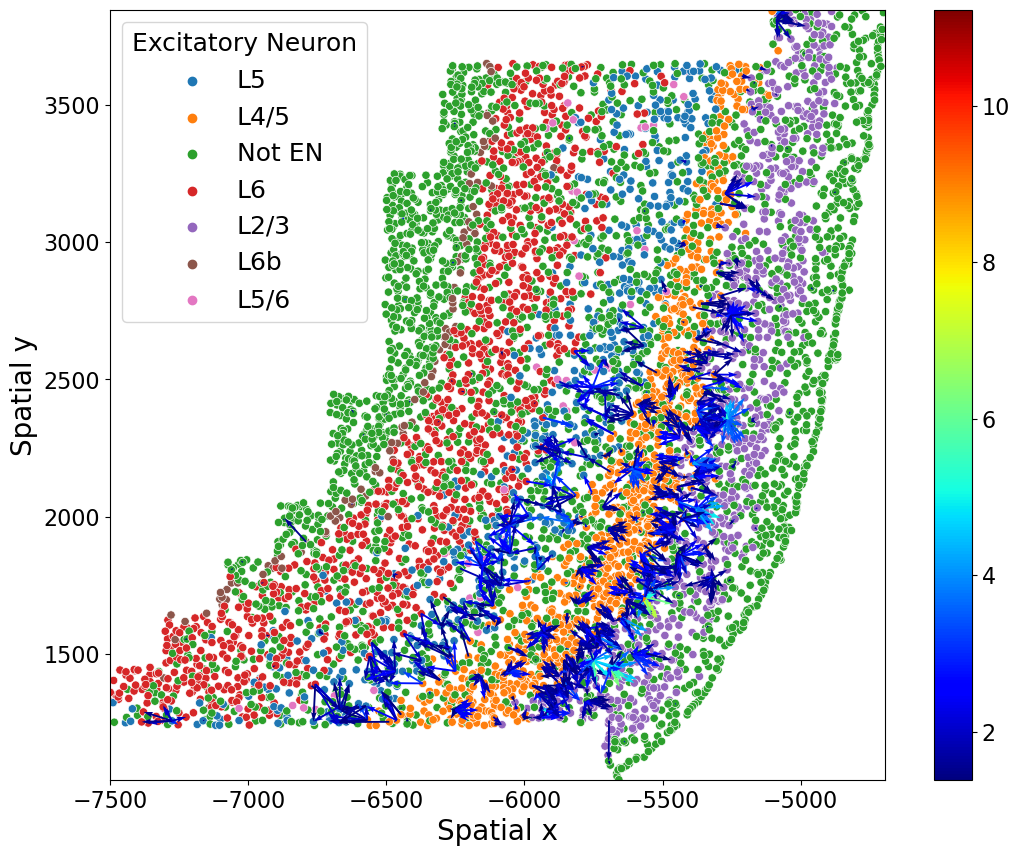

Gfap
(30685, 254)


/tmp/ipykernel_409087/4075740587.py:72: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
/tmp/ipykernel_409087/2606062087.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_x = from_x[flag]
/tmp/ipykernel_409087/2606062087.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_y = from_y[flag]
/tmp/ipykernel_409087/2606062087.py:18: FutureWarning: Series.__getitem__ tr

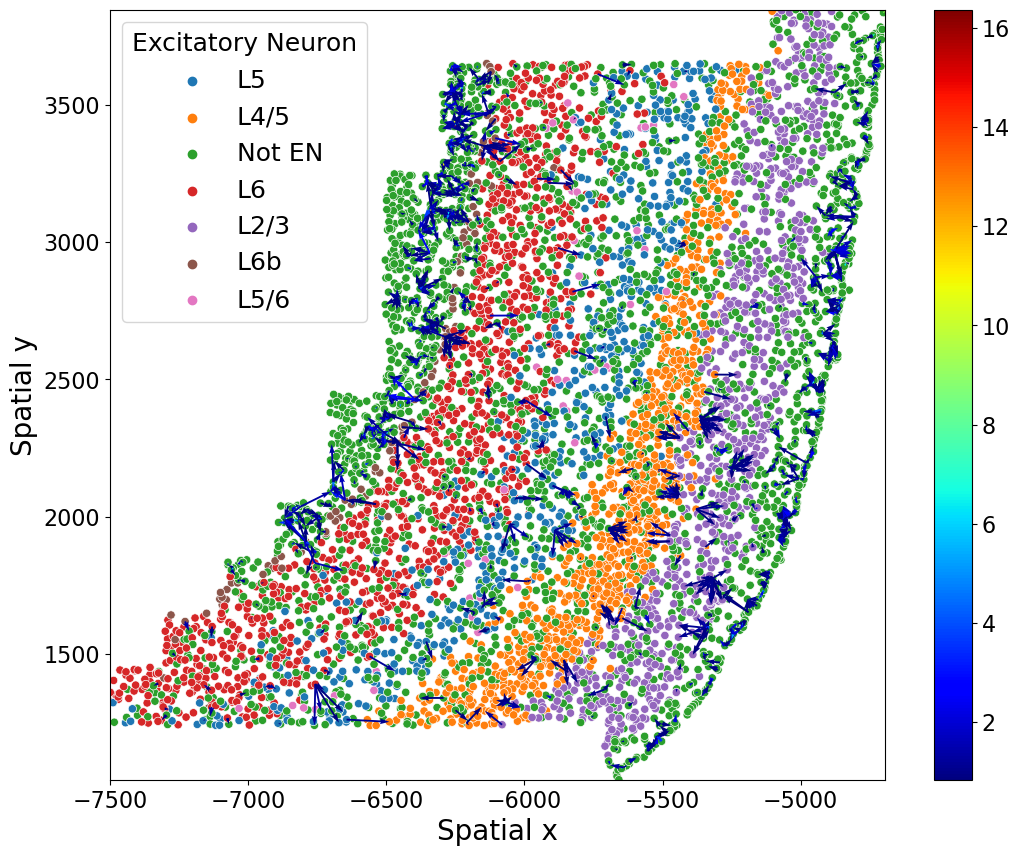

Cux2
(30685, 254)


/tmp/ipykernel_409087/4075740587.py:72: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
/tmp/ipykernel_409087/2606062087.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_x = from_x[flag]
/tmp/ipykernel_409087/2606062087.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_y = from_y[flag]
/tmp/ipykernel_409087/2606062087.py:18: FutureWarning: Series.__getitem__ tr

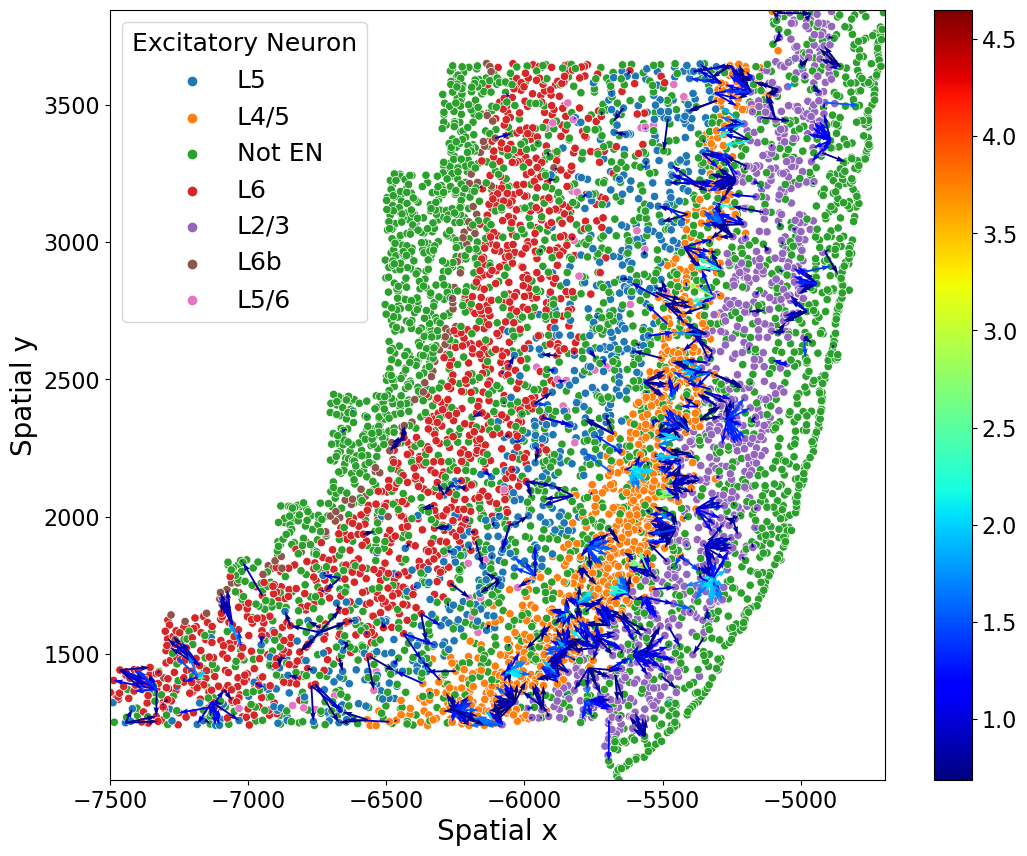

In [22]:
for genei in ['Rorb','Gfap','Cux2']:
    print(genei)
    plot_info_flow(sample=sample,df_position=df_position,idx=gene_list.index(genei),cutoff=0.05,title="Information flow of "+genei)

(30685, 254)


/tmp/ipykernel_1910502/4075740587.py:72: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  adata=adata[(adata.obs['loss']<loss_threshold)&flags,:]
/tmp/ipykernel_1910502/232207855.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_x = from_x[flag]
/tmp/ipykernel_1910502/232207855.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  from_y = from_y[flag]
/tmp/ipykernel_1910502/232207855.py:18: FutureWarning: Series.__getitem__ t

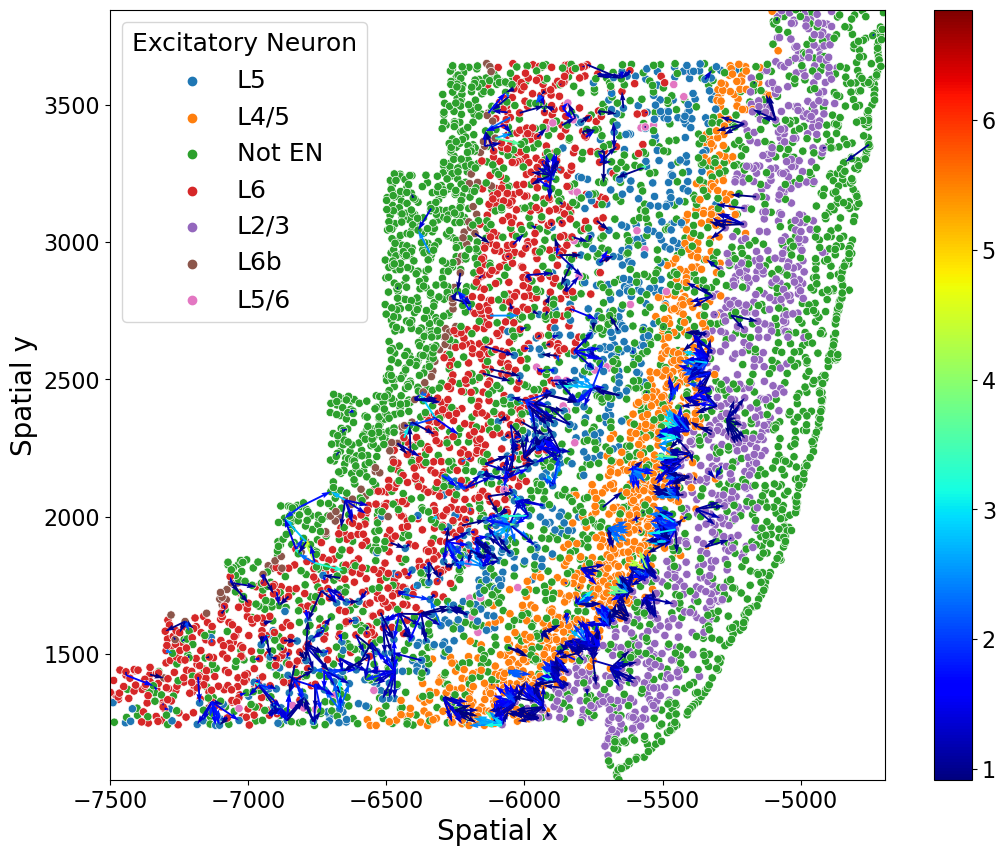

In [9]:
genei="Chrm2"
plot_info_flow(sample=sample,df_position=df_position,idx=gene_list.index(genei),cutoff=0.05,title="Information flow of "+genei)